<h1 style="font-size:35px; text-align:center; margin-bottom:30px;"><span style="color:SteelBlue">Employee Retention Classification</span></h1>
<hr>

The dataset has 14249 observations for past/present employees. Each observation includes the employee’s current employment status. We have the following features:  
    - 'status': Current employment status (Employed / Left) Administrative information  
    - 'department': Department employees belong(ed) to  
    - 'salary': Salary level relative to rest of their department  
    - 'tenure': Number of years at the company  
    - 'recently_promoted': Was the employee promoted in the last 3 years?  
    - 'n_projects': Number of projects employee is staffed on  
    - 'avg_monthly_hrs': Average number of hours worked per month  
    - 'satisfaction': Score for employee’s satisfaction with the company (higher is better)   
    - 'last_evaluation': Score for most recent evaluation of employee (higher is better)   
    - 'filed_complaint': Has the employee filed a formal complaint in the last 3 years?  

##### First, let's import libraries and load the dataset.

In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
pd.set_option('precision', 3)
pd.set_option('display.max_columns', 100)

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import pickle

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

In [2]:
# Load employee data from CSV file
df = pd.read_csv( 'employee_data.csv')

Now we're ready to jump into exploring the data!

## 1. Exploratory Analysis
### 1.1. Statistical Summary
Let's begin by displaying the dataset's basic information.

In [3]:
print ('Dimensions: ', df.shape)

Dimensions:  (14249, 10)


In [4]:
print ('Column datatypes: \n', df.dtypes)

Column datatypes: 
 avg_monthly_hrs        int64
department            object
filed_complaint      float64
last_evaluation      float64
n_projects             int64
recently_promoted    float64
salary                object
satisfaction         float64
status                object
tenure               float64
dtype: object


Summarize the distribution of attributes.

In [5]:
# Numeric attributes
df.describe()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure
count,14249.000,2058.0,12717.000,14249.000,300.0,14068.000,14068.000
mean,199.796,1.0,0.718,3.774,1.0,0.621,3.497
std,50.999,0.0,0.173,1.253,0.0,0.250,1.461
min,49.000,1.0,0.316,1.000,1.0,0.040,2.000
25%,155.000,1.0,0.564,3.000,1.0,0.450,3.000
50%,199.000,1.0,0.725,4.000,1.0,0.653,3.000
75%,245.000,1.0,0.871,5.000,1.0,0.825,4.000
max,310.000,1.0,1.000,7.000,1.0,1.000,10.000


In [6]:
# Object attributes
df.describe(include=['object'])

,department,salary,status
count,13540,14249,14249
unique,12,3,2
top,sales,low,Employed
freq,3923,6952,10857


Display the first 10 example observations from the dataset.

In [7]:
df.head(10)

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure
0,221,engineering,NaN,0.933,4,NaN,low,0.830,Left,5.0
1,232,support,NaN,NaN,3,NaN,low,0.835,Employed,2.0
2,184,sales,NaN,0.789,3,NaN,medium,0.835,Employed,3.0
3,206,sales,NaN,0.576,4,NaN,low,0.425,Employed,2.0
4,249,sales,NaN,0.845,3,NaN,low,0.779,Employed,3.0
5,140,sales,NaN,0.589,4,NaN,medium,0.660,Employed,4.0
6,121,sales,1.0,0.625,3,NaN,low,0.836,Employed,3.0
7,150,engineering,NaN,0.645,4,NaN,low,0.797,Employed,3.0
8,215,engineering,1.0,0.524,3,NaN,medium,0.715,Employed,7.0
9,269,support,NaN,0.909,5,NaN,medium,0.994,Employed,2.0


### 1.2. Data Visualization

First, plot the Pandas histogram grid for all the numeric features.

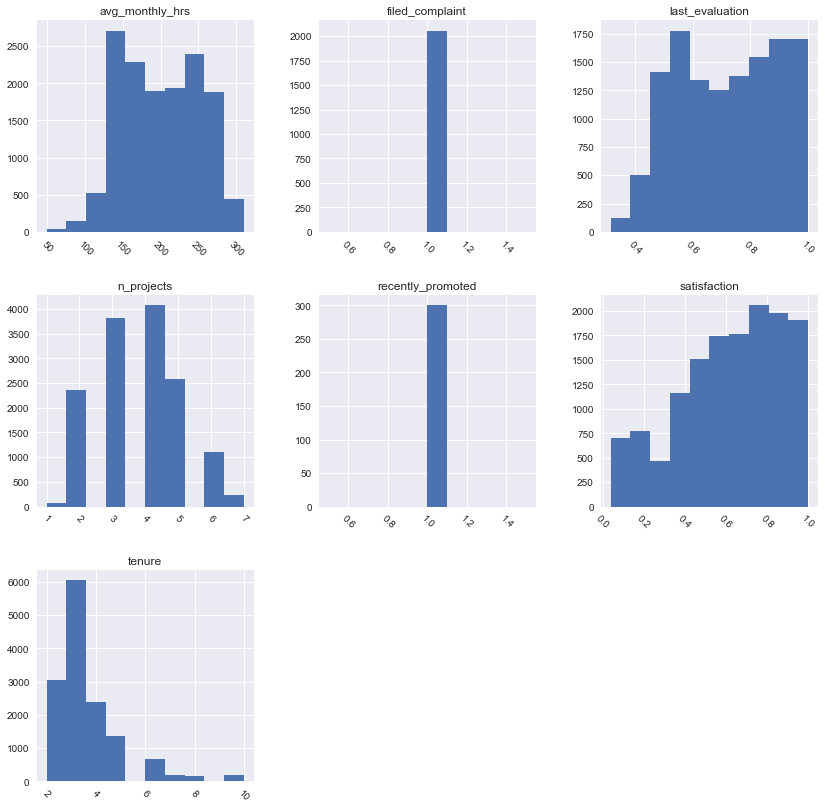

In [8]:
df.hist(figsize=(14, 14), xrot=-45)
plt.show()

Next, display bar plots for each of the categorical features.

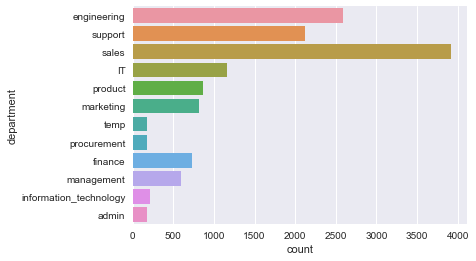

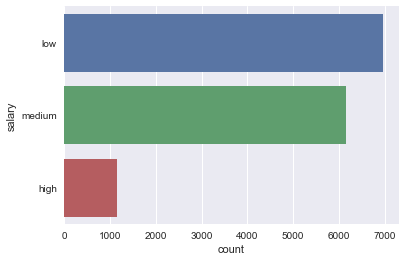

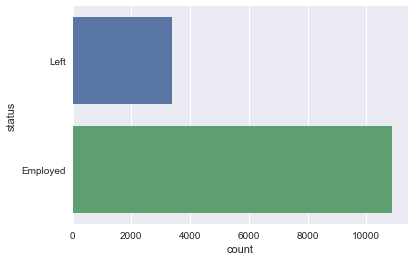

In [9]:
for feature in df.dtypes[df.dtypes=='object'].index:  
    sns.countplot(data=df, y=feature)
    plt.show()

Next, let's create some segmentations. Segmentations are powerful ways to cut the data to observe the relationship between categorical features and numeric features.  
For classification tasks, the target variable is categorical. Therefore, we recommend segmenting key numeric features by the target variable.

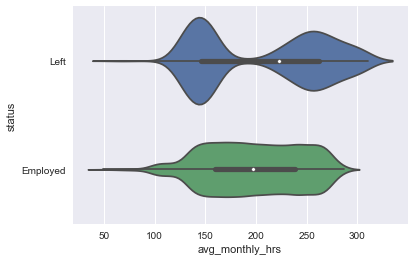

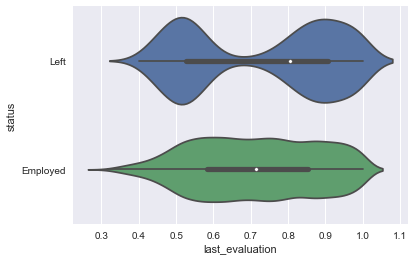

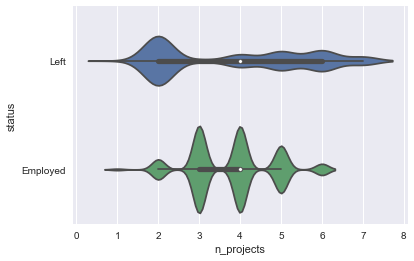

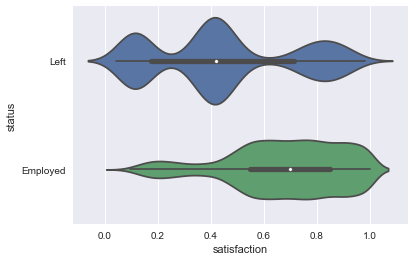

In [10]:
choosen_features = ['avg_monthly_hrs', 'last_evaluation', 'n_projects', 'satisfaction', ] 

for feature in choosen_features:  
    sns.violinplot(data=df, x=feature, y = 'status')
    plt.show()

Next, we'll try with bivariate segmentations.

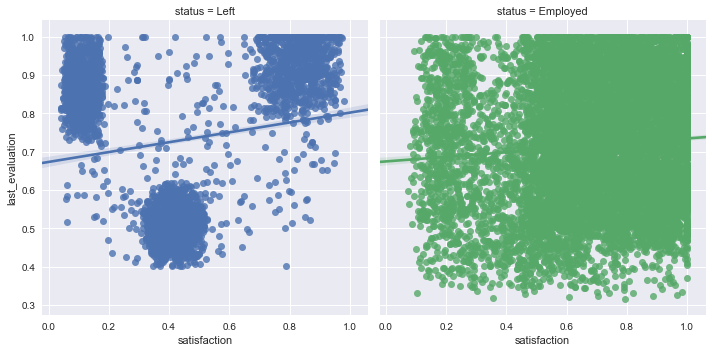

In [11]:
sns.lmplot( data=df, x='satisfaction', y='last_evaluation', col='status', hue='status')
plt.show()

As you can see, it looks like there are indeed a few clusters of people who've left. While many machine learning algorithms can learn these automatically, sometimes it helps if we explicitly highlight these clusters.

<hr style="border-color:royalblue;background-color:royalblue;height:0.1px;">

## 2. ABT Construction
### 2.1. Data Cleaning
#### Drop unwanted observations
Remember from section 1, and we can notice the 'department' feature. Let's take a closer look.
Based on the project scope, we're only trying to build a model for permanent, full-time employees.
Therefore, we should remove observations that belong to the 'temp' department. We don't want to risk them throwing off our model.

In [12]:
df = df[df.department != 'temp']

#### Fix structural errors
Remember the 'filed_complaint' and 'recently_promoted' features?  
They only had values of 1 and NaN. However, these are variables that should be either 0 or 1. Even though the NaN values are "missing," they indicate employees who have not filed complaints or those who have not been recently promoted.  
Therefore, we should fill them in with the value 0, which will turn them into real indicator variables.

In [13]:
df.filed_complaint.fillna(0, inplace=True)
df.recently_promoted.fillna(0, inplace=True)

#### Next, check for typos or inconsistent capitalization.
However, there are not any typos or inconsistent capitalizations in the class distributions for categorical features.

#### Finally, check for mislabeled classes, or classes that are labeled as separate classes 
Check the class distributions for 'department' again, we can see  'IT' and 'information_technology' as labeled as different categories?  
Let's fix that by replacing any instances of 'information_technology' with 'IT' instead.

In [14]:
df.department.replace('information_technology', 'IT', inplace=True)

#### Handle missing data
Let's display the number of missing values for each feature (both categorical and numeric).

In [15]:
df.isnull().sum()

avg_monthly_hrs         0
department            709
filed_complaint         0
last_evaluation      1351
n_projects              0
recently_promoted       0
salary                  0
satisfaction            0
status                  0
tenure                  0
dtype: int64

It looks like we have one categorical feature with missing data ('department') and one numeric feature ('last_evaluation').  
Now we can label missing values in 'department' as 'Missing' and flag 'last_evaluation' with an indicator variable of missingness (0 is not missing, and 1 is missing).

In [16]:
df['department'].fillna('Missing', inplace=True)
df.last_evaluation.fillna(0, inplace=True)

### 2.2. Feature Engineering

 Remember the scatterplot of 'satisfaction' and 'last_evaluation' for employees who have 'Left' in section 1.  
 Let's reproduce it here, just so we have it in front of us.

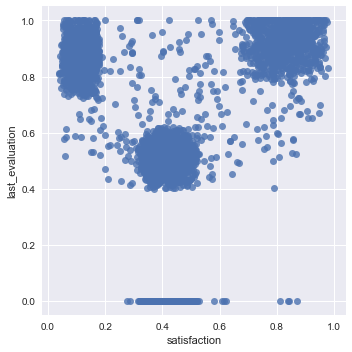

In [17]:
sns.lmplot(x='satisfaction', y='last_evaluation', data=df[df.status == 'Left'], fit_reg=False)
plt.show()

Based on the top half, it looks like there are 3 clusters of people who left.
These roughly translate to 3 indicator features we can engineer:
- 'underperformer' - last_evaluation < 0.6 and last_evaluation > 0
- 'unhappy' - satisfaction_level < 0.2
- 'overachiever' - last_evaluation > 0.8 and satisfaction > 0.7

In [18]:
df['underperformer'] = ((df.last_evaluation < 0.6) & 
                        (df.last_evaluation > 0)).astype(int)

df['unhappy'] = (df.satisfaction < 0.2).astype(int)

df['overachiever'] = ((df.last_evaluation > 0.8) & (df.satisfaction > 0.7)).astype(int)

#### Overwrite the dataframe with a version that has dummy variables for the categorical features.

In [19]:
df['status'] = pd.get_dummies( df.status ).Left
df = pd.get_dummies(df, columns=['department', 'salary'])

Save this dataframe as an analytical base table to use in next sections.

In [20]:
df.to_csv('analytical_base_table.csv', index=None)

<hr style="border-color:royalblue;background-color:royalblue;height:0.1px;">

## 3. Model Training

### 3.1. Split your dataset
First, separate the dataframe into separate objects for the target variable, y, and the input features, X.  
Then, split X and y into training and test sets.

In [21]:
y = df.status
X = df.drop('status', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1234,
                                                    stratify=df.status)

### 3.2. Build model pipelines
Next, let's set up preprocessing pipelines by creating a single pipeline dictionary with pipelines for each algorithm

In [22]:
pipelines = {
    'l1' : make_pipeline(StandardScaler(), LogisticRegression(penalty='l1' , random_state=123)),
    'l2' : make_pipeline(StandardScaler(), LogisticRegression(penalty='l2' , random_state=123)),
    'rf' : make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123)),
    'gb' : make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=123))
}

### 3.3. Declare hyperparameters to tune
Let's declare hyperparameters grids to tune for each algorithm and store them in a dictionary for ease of access.

In [23]:
# Logistic Regression hyperparameters
l1_hyperparameters = {
    'logisticregression__C' : np.linspace(1e-3, 1e3, 10),
}

l2_hyperparameters = {
    'logisticregression__C' : np.linspace(1e-3, 1e3, 10),
}

# Random Forest hyperparameters
rf_hyperparameters = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33]
}

# Boosted Tree hyperparameters
gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators': [100, 200],
    'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingclassifier__max_depth': [1, 3, 5]
}

# Create hyperparameters dictionary
hyperparameters = {
    'l1' : l1_hyperparameters,
    'l2' : l2_hyperparameters,
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters
}

### 3.4. Fit and tune models with cross-validation  
Create a fitted_models dictionary that includes models that have been tuned using cross-validation.

In [24]:
fitted_models = {}

for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    model.fit(X_train, y_train)
    fitted_models[name] = model

### 3.5. Evaluate metrics
Finally, it's time to evaluate our models and pick the best one.
#### Cross-validated score
We'll first evaluate the models by looking at their cross-validated performance on the training set.  
Daisplay the best_score_ attribute for each fitted model.

In [25]:
for name, model in fitted_models.items():
    print( name, model.best_score_ )

l1 0.835169717434
l2 0.835258574729
rf 0.978763106451
gb 0.975119957348


##### Holdout accuracy
Those scores are holdout accuracy scores. For classification problems, the default scoring metric is accuracy.
Accuracy is simply the percent of observations correctly classified by the model.
Because it's the average accuracy from the holdout folds, higher is almost always better.
However, straight accuracy is not always the best way to evaluate a classification model.

##### Imbalanced classes
Specifically, it's not a good metric when evaluating imbalanced classes in your target variable.  
Let's take an extreme example:  
```"Hypothetically, let's say only 5% of our observations were 'Left' and the other 95% were 'Employed'.
Well, we could make a brain-dead simple model that only predicts 'Employed' 100% of the time.
This model would achieve 95% accuracy, simply because 95% of the observations are 'Employed'!"```  
Therefore, we need a more advanced metric... one that works for imbalanced classes.

### 3.6. Area under ROC curve  
**Area under ROC curve** is the most reliable metric for classification tasks.  
Plot the ROC curve and display the performance of each model in fitted_models on the test set.

l1 0.895961740393
l2 0.895956882295
rf 0.991214476023
gb 0.988635866785


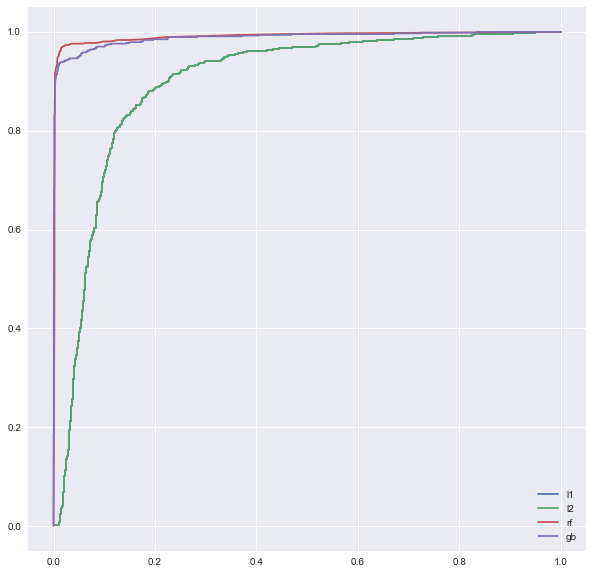

In [26]:
fig = plt.figure(figsize=(10,10))
for name, model in fitted_models.items():
    pred = model.predict_proba(X_test)
    pred = [p[1] for p in pred]
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    print(name, auc(fpr, tpr))
    plt.plot(fpr, tpr, label= name)
plt.legend(loc='lower right')
plt.show()

We could notice that **'rf'** model had the highest test AUROC and also have the highest cross-validated score.  
Now, let's save the winning model.

In [27]:
with open('final_model.pkl', 'wb') as f:
    pickle.dump(fitted_models['rf'].best_estimator_, f)